### Implement a code to solve the full Hamiltonian with adaptive step size

The system is of the form: 
$$
\begin{align}
dq&=pdt \\
dp&= F(q) dt - \gamma p dt + \sqrt{2 \frac{\gamma}{\beta}} dW
\end{align}
$$
with $F(q)= q^2/2$.

We have using $\frac{dt}{ds} = g(x)$ that the system below has the same invariant distribution: 
$$
\begin{align}
dq&=g(q)pdt \\
dp&= g(q) F(q) dt - \gamma g(q) p dt + \sqrt{2 \frac{\gamma}{\beta} g(q)} dW
\end{align}
$$
with $F(q)= q^2/2$.

With the method BAOAB, we have: 
1. Step A
$$
dq=pdt\\
\dot{p}=0
$$
can not be simply generated as: 
$$
q_{n+1}=q_n+h p_n g(q_n)
$$
due to the non linearity of the term $g(q_n)$. 
Let's try and get a better method by using: 
$$
q_{n+1}=q_n+h p_n g(\frac{q_n+q_{n+1}}{2})
$$
where $q_{n+1/2} = \frac{q_n+q_{n+1}}{2}$.

We have:  
$$
q_{n+1/2} = q_n + \frac{h}{2} p g(q_{n+1/2}) \\
g(q_{n+1/2}) = g( q_n + \frac{h}{2} p g(q_{n+1/2})) \\
g_{n+1/2} = g( q_n + \frac{h}{2} p g_{n+1/2}) \\
$$
and now we can use fixed point iterations by setting : 
$$
g^0_{n+1/2} = g( q_n + \frac{h}{2} p g_{n}) \\
g^1_{n+1/2} = g( q_n + \frac{h}{2} p g^0_{n+1/2}) \\
g^2_{n+1/2} = g( q_n + \frac{h}{2} p g^1_{n+1/2}) \\
g^3_{n+1/2} = g( q_n + \frac{h}{2} p g^2_{n+1/2}) \\
\dots
$$

and finally compute: 
$$
q_{n+1}=q_n+h p_n g^l_{n+1/2}
$$


2. Step B . 
$$
dp=g(q) F(q) ds\\
\dot{q}=0
$$
is generated as: 
$$
p_{n+1}=p_n+g(q_n) F(q_n) h\\
$$

3. Step O
$$
dp=-g(q) \gamma p ds + \sqrt{2 \gamma \beta^-1 g(q)} dW(s)\\
\dot{q}=0
$$
is generated as: 
$$
p_{n+1}=\exp(-\gamma g(q_n) h) p_n+ \sqrt{\frac{1-\exp(2 \gamma g(q_n)h)}{\beta}} \mathcal{N}(0,1)
$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



### Find an adaptive step size that works with the problem 

This is not so easy to do, therefore we would like to establish a step size that we control very well. Say we would like a step size with values between $\Delta t_{min} =0.001$ and $\Delta t_{max}=0.2$, with a growth to the step size we like control by the parameter $R$. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


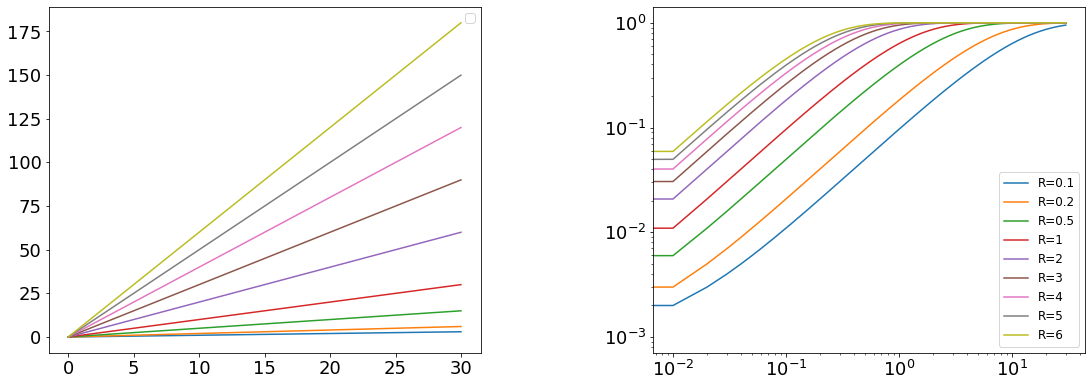

In [2]:
def var_stepsize1(x,dtmin,R):
    return (np.abs(x))*R+dtmin

def var_stepsize2(x,dtmin, dtmax, R):
    return (dtmax-dtmin)/dtmax*(1-np.exp(-np.abs(x)*R))+dtmin/dtmax


x=np.arange(0,30,0.01)

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(18,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)

Rrange=[0.1,0.2,0.5,1,2,3,4,5,6]
for ri in Rrange:
    ax1.plot(x,var_stepsize1(x,0.0001, ri))
    ax2.loglog(x,var_stepsize2(x,0.0001, 0.1,ri),label="R="+str(ri))
ax1.legend()
ax2.legend()

In [77]:
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/underdamped_adaptive.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/underdamped.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/underdamped_adaptive2.py"

<Figure size 432x288 with 0 Axes>

In [78]:
T=10
h = 0.1
gamma = 0.1
beta=1
# compile
N=1
%time qp=method_baoab(N,T,gamma,beta,h)

# run for 1 no compiler 
N=1
%time qp=method_baoab_ada(N,T,gamma,beta,h)

dtbounds=np.array([0.01,0.1])
%time qp=method_baoab_ada2(N,T,gamma,beta,h,dtbounds)

CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.23 s
CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.07 s
CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.27 s


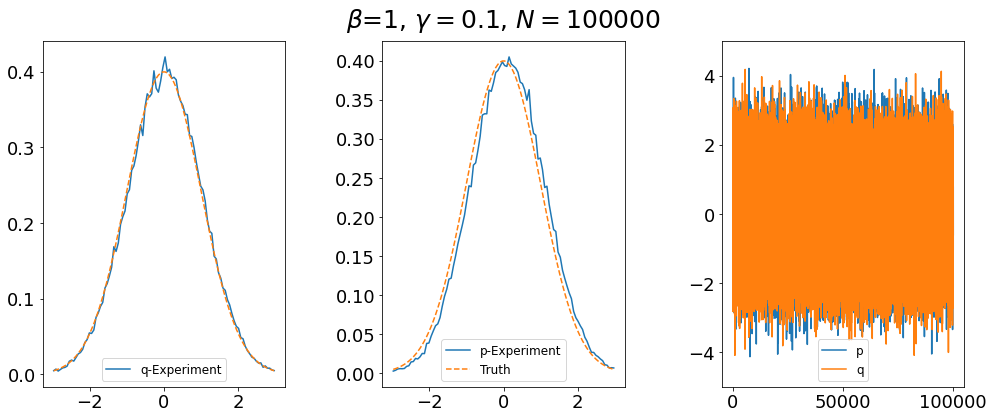

In [38]:
## Non adaptive time steps
T=100
h = 0.1
gamma = 0.1
beta=1
N=10**5
qp4=method_baoab(N,T,gamma,beta,h)
plot_qp(qp4,beta,gamma)

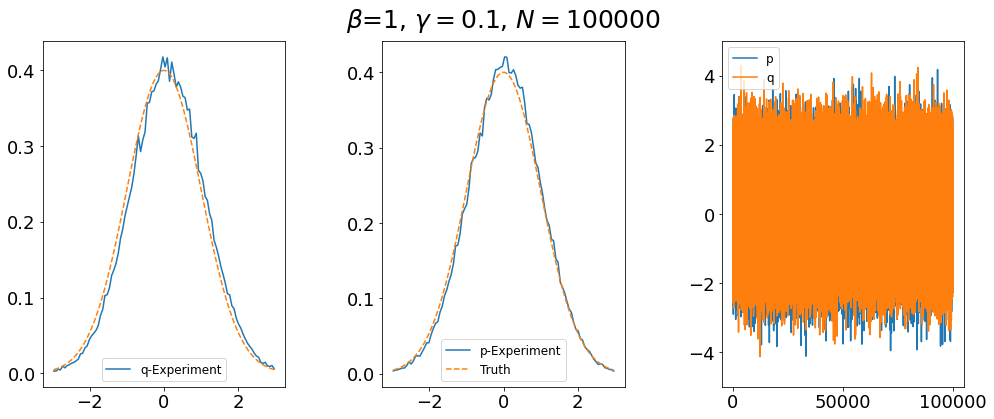

In [37]:
## Adaptive time steps with y set to 1. 
T=100
h = 0.5
gamma = 0.1
beta=1
N=10**5
qp2=method_baoab_ada(N,T,gamma,beta,h)
plot_qp(qp2,beta,gamma)

Now that it seems to be working with a simple adaptive function g(x), we can try with one that is a bit more elaborated and tailored to the problem of interest. Similarly to what is done for the overdamped, we select a function $g(x)$ which is bounded. Typically, we choose: 
$$
g^{-1}(x) = \frac{\sqrt{ \|f(x)\|^2+m^2}}{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1},
$$
such that : 
$$
g(x) = \frac{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1}{\sqrt{ \|f(x)\|^2+m^2}} 
$$
where $f(x)=-\nabla V(x)$.

(0.0, 0.2)

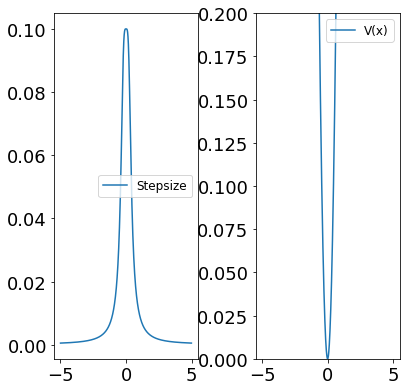

In [88]:
## Adaptive time steps with y set to 1. 
def g(x,h,dtbounds):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """
    dtmin=dtbounds[0]
    dtmax=dtbounds[1]

    M=h/dtmin
    m=h/dtmax

    x3=np.power(x,3)

    # value of function f, f' and f^2
    f=np.abs(x)
    f2 = f*f

    #compute the value of phi(f(x)) = \sqrt{f(x)^2}
    phif2 = f2*f2

    # value of m^2
    m2 = m*m

    #compute gx
    gx_den=np.sqrt(phif2+m2)
    gx_num = gx_den/M + 1 
    gx=gx_num/gx_den

    #return
    re=gx
    return re

fig, (ax1,ax2)= plt.subplots(1,2,figsize=(6,6)) 
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
dtbounds=np.array([0.0001,0.1])
h = 0.01
x = np.arange(-5,5,0.01)
ax1.plot(x,g(x,h,dtbounds)*h,label="Stepsize")
ax1.legend()

ax2.plot(x,x*x/2,label="V(x)")
ax2.legend()
ax2.set_ylim(0,0.2)


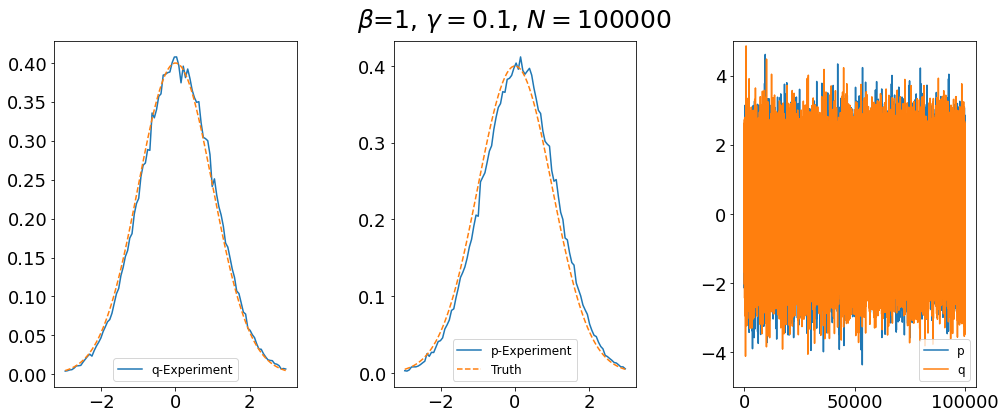

In [89]:
dtbounds=np.array([0.0001,0.1])
h = 0.01
T=100
gamma = 0.1
beta=1
N=10**5
qp2=method_baoab_ada2(N,T,gamma,beta,h,dtbounds)
plot_qp(qp2,beta,gamma)

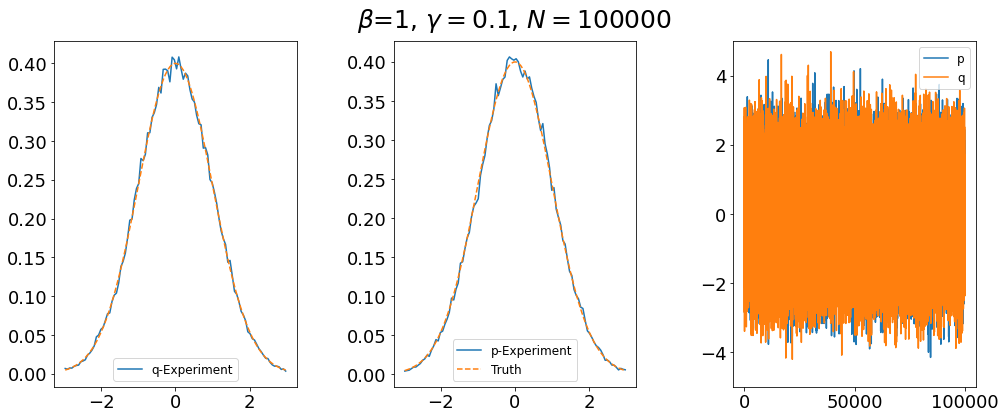

In [90]:
dtbounds=np.array([0.01,0.1])
h = 1
T=200
gamma = 0.1
beta=1
N=10**5
qp2=method_baoab_ada2(N,T,gamma,beta,h,dtbounds)
plot_qp(qp2,beta,gamma)